In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt
import networkx as nx
import itertools

df = pd.read_csv("hessle_with_features.csv")
df['styles'] = df['styles'].str.split(', ')

genre_correction = {
    'break beat' : 'breakbeat',
    "abstract" : "experimental",
    "Garage House" : "UK Garage",
    "Minimal" : "Dub Techno"
}

df['styles'] = df['styles'].apply(lambda genres: [genre_correction.get(genre, genre) for genre in genres])


In [2]:
def calculate_weights(genres):
    weight_per_genre = 1 / len(genres)
    return {genre: weight_per_genre for genre in genres}

df['genre_weights'] = df['styles'].apply(calculate_weights)
df_exploded = df.explode('styles')



In [10]:
df.columns

Index(['Unnamed: 0', 'title', 'artist', 'album', 'year', 'genre', 'label',
       'file_path', 'discogs_id', 'genres', 'styles', 'tempo', 'centroid_mean',
       'centroid_std', 'spread_mean', 'spread_std', 'rolloff_mean',
       'rolloff_std', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean',
       'rms_std', 'harmony_mean', 'harmony_var', 'percu_mean', 'percu_var',
       'mfcc_1_mean', 'mfcc_2_mean', 'mfcc_3_mean', 'mfcc_4_mean',
       'mfcc_5_mean', 'mfcc_6_mean', 'mfcc_7_mean', 'mfcc_8_mean',
       'mfcc_9_mean', 'mfcc_10_mean', 'mfcc_11_mean', 'mfcc_12_mean',
       'mfcc_13_mean', 'mfcc_1_var', 'mfcc_2_var', 'mfcc_3_var', 'mfcc_4_var',
       'mfcc_5_var', 'mfcc_6_var', 'mfcc_7_var', 'mfcc_8_var', 'mfcc_9_var',
       'mfcc_10_var', 'mfcc_11_var', 'mfcc_12_var', 'mfcc_13_var',
       'genre_weights'],
      dtype='object')

In [12]:
df.iloc[0]

Unnamed: 0                                                          0
title                                                    Put You Down
artist                                                            TRG
album                                                    Put You Down
year                                                              NaN
genre                                                         Dubstep
label                                                    Hessle Audio
file_path           /mnt/d/MIR_music/Hessle/[HES001] TRG - Put You...
discogs_id                                                     951830
genres                                                     Electronic
styles                                           [UK Garage, Dubstep]
tempo                                                      135.999178
centroid_mean                                               2218.0653
centroid_std                                              1040.801077
spread_mean         

In [3]:
genre_counts = df_exploded['styles'].value_counts()
genre_counts_normalized = genre_counts / genre_counts.sum()

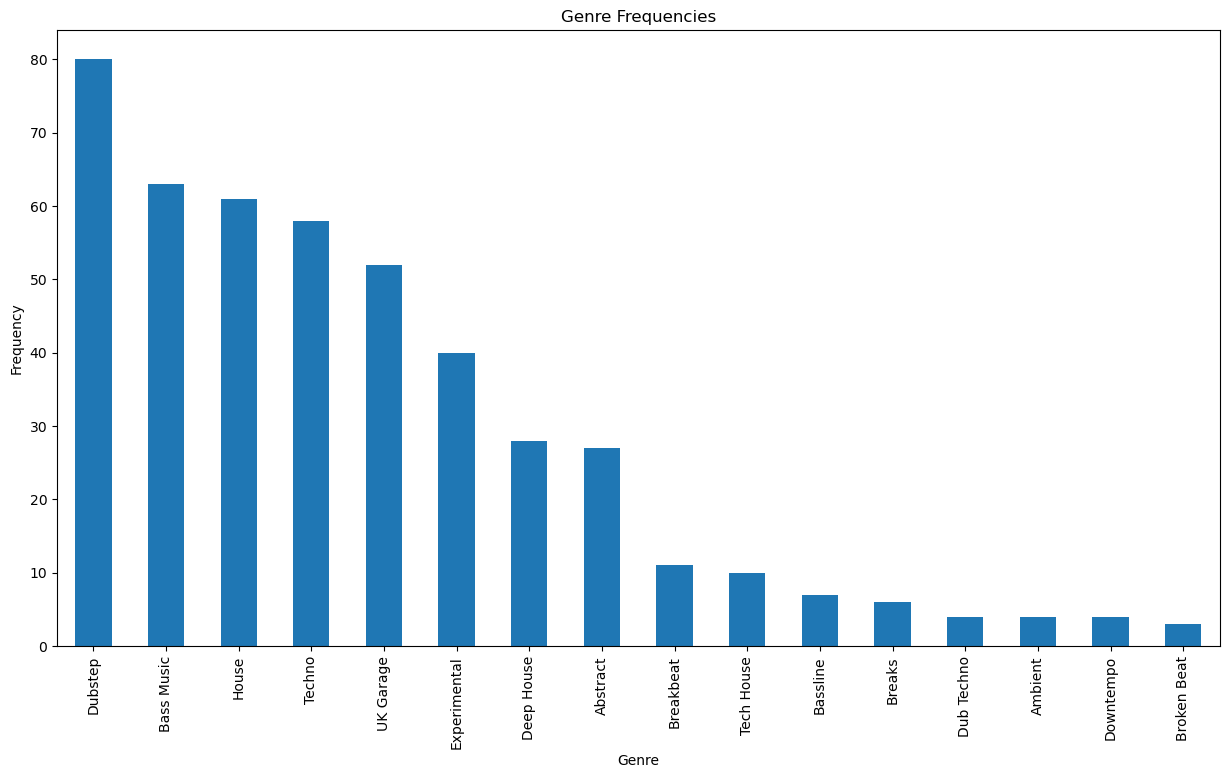

In [4]:
genre_counts.plot(kind='bar', figsize=(15, 8))
plt.title('Genre Frequencies')
plt.ylabel('Frequency')
plt.xlabel('Genre')
plt.show()

In [ ]:
feat1 = 'spread_std'
feat2 = 'spread_mean'
feat3 = 'harmony_var'
feat4 = 'rms_mean'

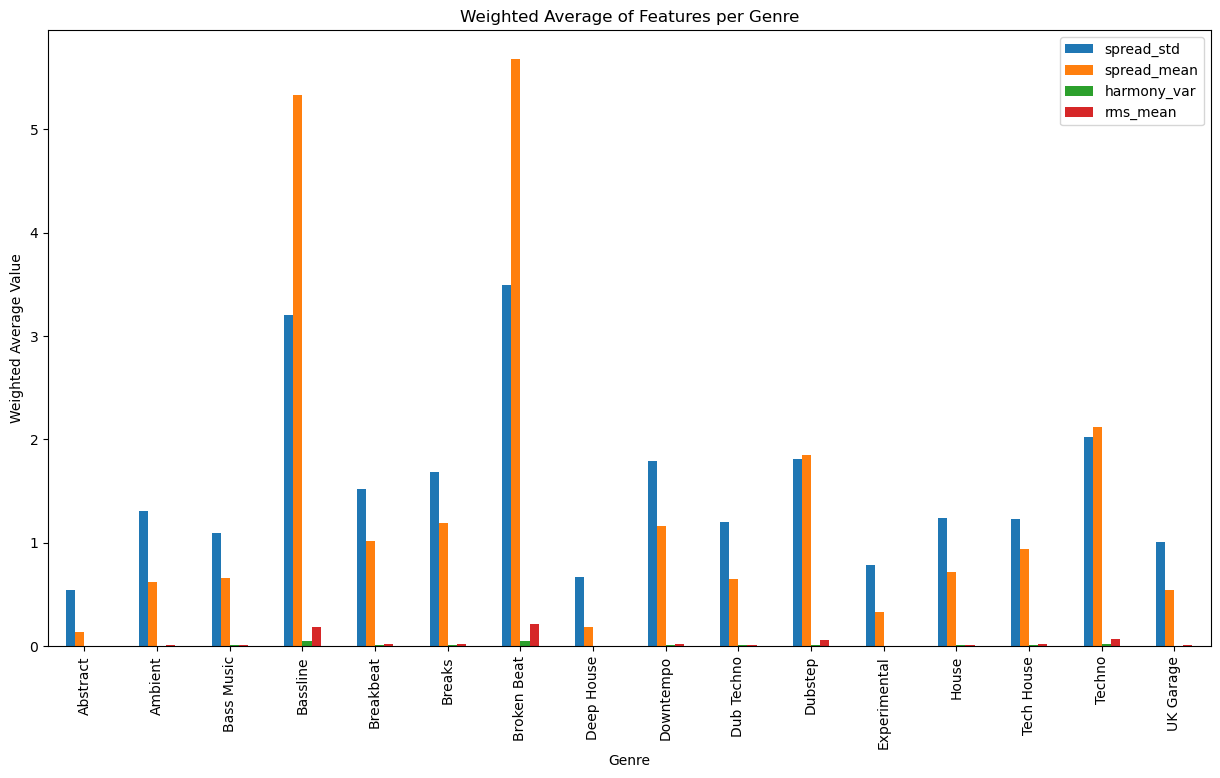

In [16]:


for feature in [feat1, feat2, feat3, feat4]:
    df_exploded[feature] = df_exploded.apply(lambda row: row[feature] * row['genre_weights'][row['styles']], axis=1)

grouped = df_exploded.groupby('styles')[[feat1, feat2, feat3, feat4]].mean()

# Plotting
grouped.plot(kind='bar', figsize=(15, 8))
plt.title('Weighted Average of Features per Genre')
plt.ylabel('Weighted Average Value')
plt.xlabel('Genre')
plt.show()

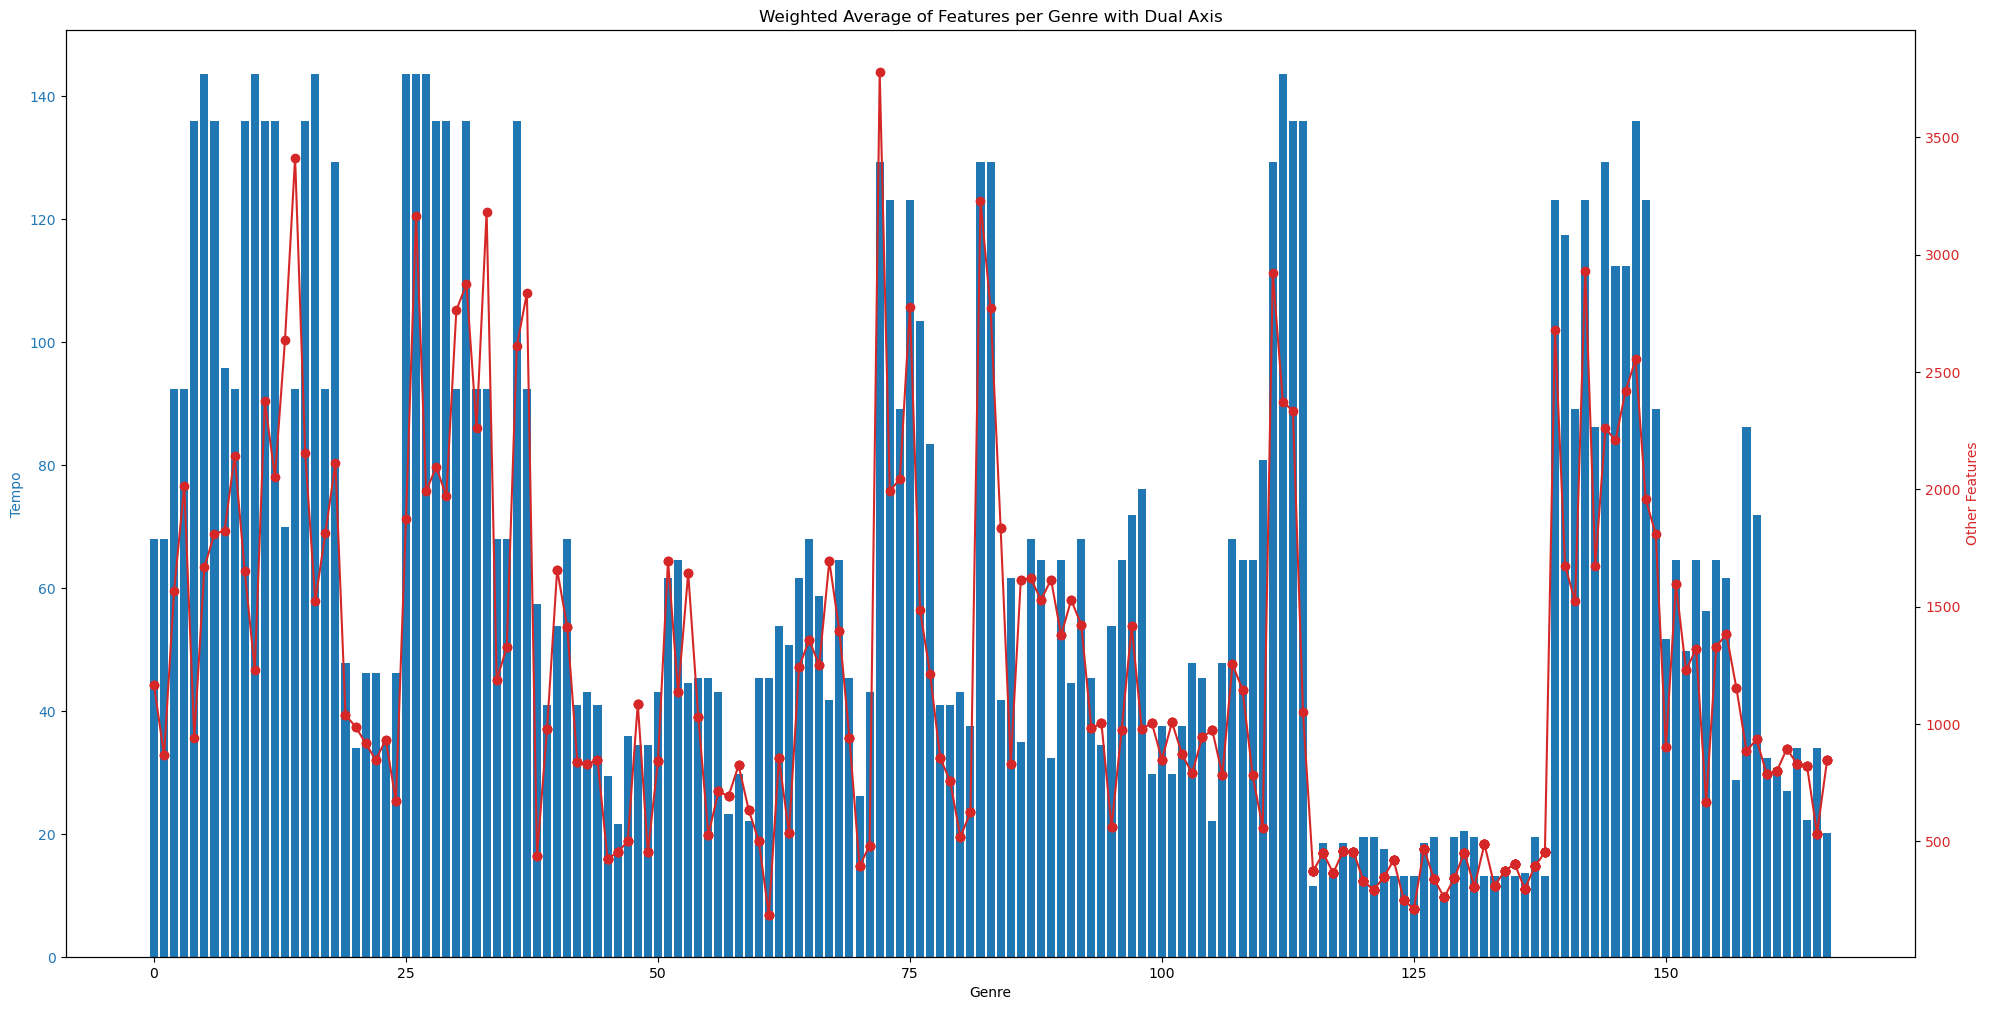

In [13]:
# ## i need to re-evaluate tempo, granted there is a good amount of dubstep which one could easily hear as 70 bpm, most house/techno falls
# # between 110 on the very slow side to 140+ high side. Also most dubstep producers would probably tell you they hear/program the music
# # at 140 bpm with halftime sensibility
# # grouped = df_exploded.groupby('styles')[['tempo', 'centroid_mean', 'spread_mean', 'rolloff_mean']].mean()

# fig, ax1 = plt.subplots(figsize=(20, 10))

# # Assuming 'grouped' is your DataFrame after applying weights
# # Plot the 'tempo' on the first axis
# color = 'tab:blue'
# ax1.set_xlabel('Genre')
# ax1.set_ylabel('Tempo', color=color)
# ax1.bar(df_exploded.index, df_exploded['tempo'], color=color)
# ax1.tick_params(axis='y', labelcolor=color)

# # Create a second axis for other features
# ax2 = ax1.twinx()
# color = 'tab:red'
# ax2.set_ylabel('Other Features', color=color)
# # Assuming other features are averaged and stored in 'other_features'
# other_features = df_exploded[['centroid_mean', 'spread_mean', 'rolloff_mean']].mean(axis=1)
# ax2.plot(df_exploded.index, other_features, color=color, marker='o')
# ax2.tick_params(axis='y', labelcolor=color)

# fig.tight_layout()
# plt.title('Weighted Average of Features per Genre with Dual Axis')
# plt.show()

In [17]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

style_means = df_exploded.groupby('styles')[[feat1, feat2, feat3, feat4]].mean()
scaler = StandardScaler()
scaled_style_means = scaler.fit_transform(style_means)
similarity_matrix = cosine_similarity(scaled_style_means)
similarity_df = pd.DataFrame(similarity_matrix, index=style_means.index, columns=style_means.index)

In [18]:
# adjusting similarity based on frequency of genre

for genre in genre_counts_normalized.keys():
    similarity_df[genre] = similarity_df[genre].apply(lambda x: x / genre_counts_normalized[genre])

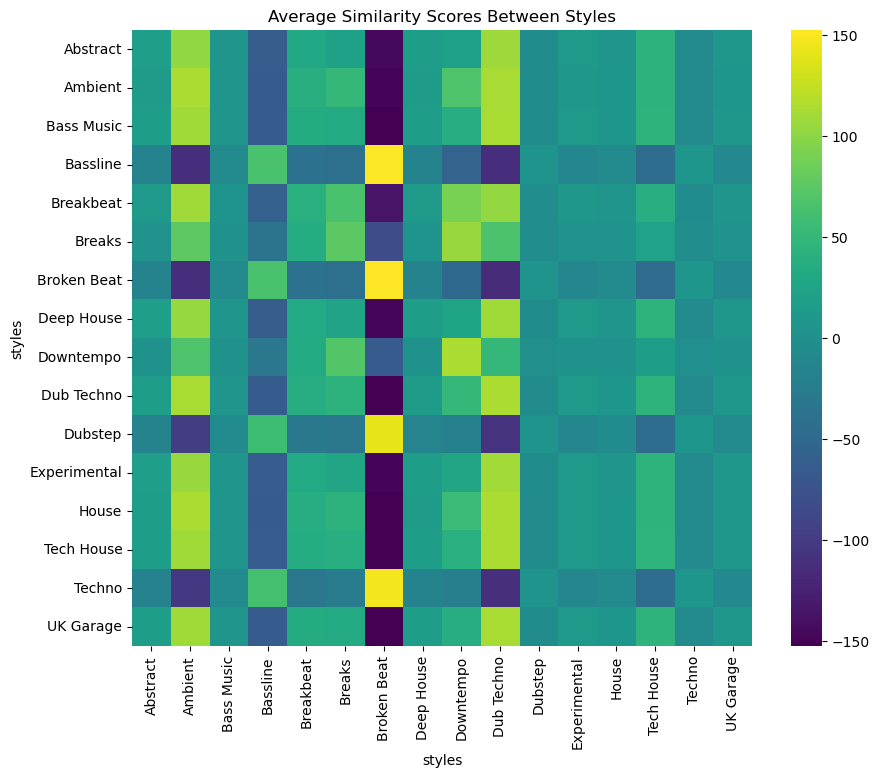

In [19]:
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_df, annot=False, cmap="viridis")
plt.title('Average Similarity Scores Between Styles')
plt.show()

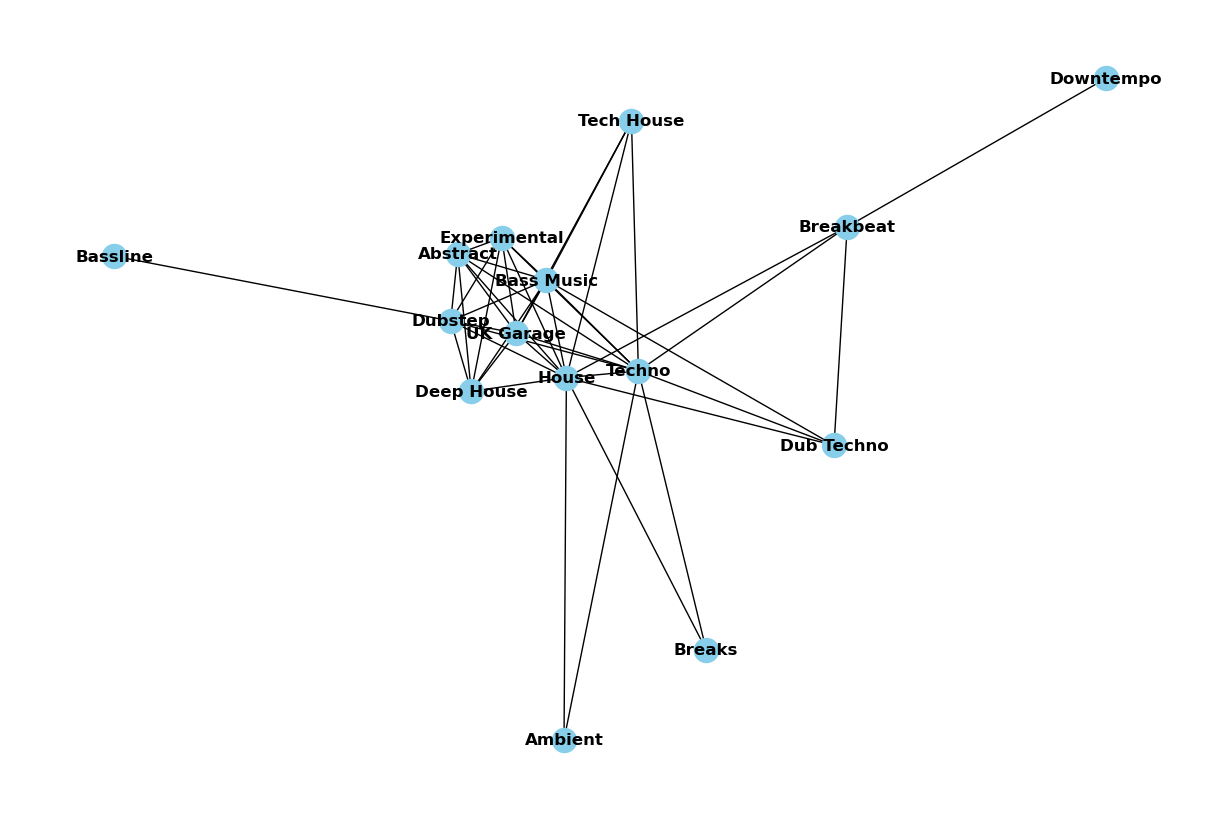

In [21]:
G = nx.Graph()

for genres in df['styles']:
    for genre in genres:
        if genre not in G:
            G.add_node(genre)
    for genre_pair in itertools.combinations(genres, 2):
        if G.has_edge(*genre_pair):
            G[genre_pair[0]][genre_pair[1]]['weight'] += 1
        else:
            G.add_edge(*genre_pair, weight=1)

outlier_genre = 'Broken Beat'
if outlier_genre in G:
    G.remove_node(outlier_genre)

plt.figure(figsize=(12, 8))
nx.draw(G, with_labels=True, font_weight='bold', node_color='skyblue')
plt.show()
